# Sentiment Analysis of Movie Reviews using TfidfVectorizer and Classifiers from scikit-learn

In this notebook, I perform sentiment analysis of movie reviews using classes available in scikit-learn.

The dataset consists of 50k highly polarized (*clearly* favourable or unfavourable) movie reviews from IMBD. The set is partitioned into a labelled train set of 25k reviews and a labelled test set of 25k reviews. (There is also an unlabelled, unsupervised set of 25k reviews.) The reviews are preprocessed by lower-casing, removing HTML tags, and removing punctutation. The reviews are then tokenized, removing English stop words, and stemmed. Corpus vectorization is implemented using TfidfVectorizer. Multiple classification models from scikit-learn are trained and tested on the results. The best performing model is pickled for later deployment.

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from datasets import load_dataset
from scipy.stats import loguniform, uniform
from nltk import PorterStemmer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from app.cleaner.preprocessor import Preprocessor
from app.cleaner.tokenizer import Tokenizer

## Load the IMDB Dataset

In [2]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

In the following DataFrame samples, a label of 0 corresponds to a negative review (*i.e.,* thumbs-down) whereas a label of 1 corresponds to a positive review (*i.e.,* thumbs-up).

In [3]:
train.sample(5)

,text,label
8981,This centers on unironic notions of coming to ...,0
22005,"Ultra-grim crime drama from Pou-Soi Cheang, th...",1
6530,"I just saw this movie, and I have to say that ...",0
10919,"*** THIS CONTAINS MANY, MANY SPOILERS, NOT THA...",0
3280,I was seriously looking forward to seeing this...,0


In [4]:
test.sample(5)

,text,label
2557,I think this was a HORRIBLE mistake on Disney'...,0
17035,"Well, on the day that Rob Schneider plunges hi...",1
16912,Loved today's show!!! It was a variety and not...,1
13468,"if u haven't seen Vijay in ""Ghillli"", ""Gilly"" ...",1
1248,***May contain spoilers***<br /><br />I had ve...,0


## Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


I plot the distribution of movie review labels in the train set.

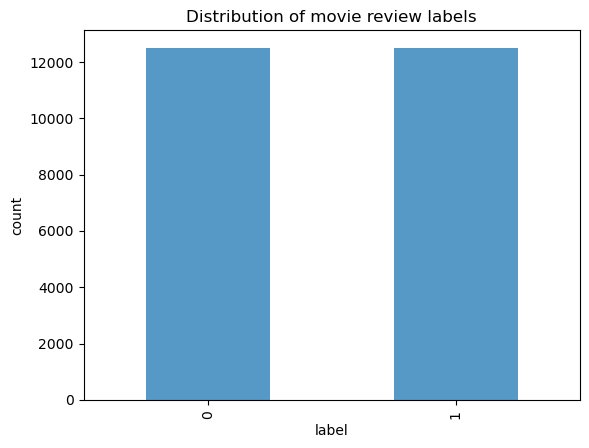

In [6]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of movie review labels')
ax.legend().set_visible(False)
plt.show()

From the above bar graph, the train set appears to be balanced. To confirm:

In [7]:
train['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

It is instructive to read a handful of reviews to better understand what is meant by "highly polarized."

In [8]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [9]:
thumbs_up_samples = thumbs_ups['text'].sample(3).to_list()
print('\n\n'.join(thumbs_up_samples))

This is a decent little flick made in Michigan, about a guy that is haunted by his past, with his abusive stepfather (Gunnar Hansen) and has grown up not-so-well-adjusted. In fact, he's absolutely bonkers, but tries not to be too obvious. He's got an entourage too, his own little demon & angel that follow him around. The demon never says a word but really, doesn't have to, and he's Max Schreck-creepy. Let's just say that the angel pretty much spins his wheels in this, as Eric is busy doing things that make him feel better, like "freeing" people that he decides need it, mostly beautiful young women. This is a decent portrayal of madness, and you're kind of on your own at some point to figure out some of what's going on, but overall, I watched this from start to finish very focused on the film because it definitely held my interest. It's a little lacking in some areas but nothing I can really lay my finger on. A decent effort and worth seeing IF you like serial killer flicks.

Noni Hazle

In [10]:
thumbs_down_samples = thumbs_downs['text'].sample(3).to_list()
print('\n\n'.join(thumbs_down_samples))

After a quasi-Gothic, all-fruity music video, the movie starts with Cassidy the lead singer killing herself. In a perfect world that would be that and the end credits would roll. We don't live n that world. The insipid band members decide to go to some clown to contact her dead essence. When I say clown, I mean actual clown. He tell them they're all going to die via Cassidy's ghost (the spirit possesses Dora, one of the band-mates) We couldn't care less as the characters are all boring, vapid, and extremely horribly acted. Written by Adam Hackbarth (an incredibly apropos surname if there ever was one), and directed by Corbin Timbrook (who after The attendant, and Tower of blood, HAS to know that he keeps making crap for a living), this movie s a constant battle between the film's incompetence and the viewer's need to stay awake. Not enough blood to appease gore-hounds, nor enough nudity to satisfy pervs. This movie in fact has absolutely nothing to recommend to absolutely anyone.<br />

Generally, it is pretty clear from reading a particular review whether it is a thumbs-up or thumbs-down.

## Preprocessor

The preprocessor transforms movie reviews by lower-casing, removing HTML tags, and removing punctuation.

In [11]:
preprocessor = Preprocessor()

To see the preprocessor in action, pick a random movie review:

In [12]:
doc = train['text'].sample()
doc_preprocessed = preprocessor.transform(doc)

print(doc.to_list()[0])
print()
print(doc_preprocessed[0])

Yes, Marie Dresler drinks prune juice that she thinks is poison and she exits running.<br /><br />Dresler is good. Never my cup of tea but she is a solid performer who surely holds the screen.<br /><br />I watched this for Polly Moran, whom I've seen elsewhere. Here, Moran is OK -- just OK -- as Dressler's shrewish friend/foe. Too bad she has sunk into nearly total oblivion.<br /><br />The plot is good hearted. Bad guys try to rob the townspeople. Dressler triumphs and all ends well.<br /><br />I do wonder about the central plot mechanism: bonds. This came out during the Depression so maybe everyone was familiar with bonds and what they can do if used well and if used wrongly. I, however, not of that era, am vaguely familiar with them. They're like stocks only different, right? It seems odd to build a story about The Little Man around a somewhat sophisticated monetary entity.

yes marie dresler drinks prune juice that she thinks is poison and she exits running  dresler is good never my

## Tokenizer

The tokenizer removes English stop words and stems the corpus.

In [13]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

To see the tokenizer in action, transform the previously preprocessed movie review.

In [14]:
doc_tokenized = tokenizer.transform(doc_preprocessed)

print(doc_preprocessed[0])
print()
print(doc_tokenized[0])

yes marie dresler drinks prune juice that she thinks is poison and she exits running  dresler is good never my cup of tea but she is a solid performer who surely holds the screen  i watched this for polly moran whom ive seen elsewhere here moran is ok  just ok  as dresslers shrewish friend foe too bad she has sunk into nearly total oblivion  the plot is good hearted bad guys try to rob the townspeople dressler triumphs and all ends well  i do wonder about the central plot mechanism bonds this came out during the depression so maybe everyone was familiar with bonds and what they can do if used well and if used wrongly i however not of that era am vaguely familiar with them theyre like stocks only different right it seems odd to build a story about the little man around a somewhat sophisticated monetary entity

ye mari dresler drink prune juic think poison exit run dresler good cup tea solid perform sure hold screen watch polli moran ive seen moran ok just ok dressler shrewish friend foe

## Vectorizer

I use `TfidfVectorizer` to map documents to vectors.

In [15]:
vectorizer = TfidfVectorizer(
    max_df = 0.95,
    min_df = 2,
    max_features = 10_000,
    strip_accents='unicode'
)

cleaner = Pipeline([
    ('preprocessor', preprocessor),
    ('tokenizer', tokenizer),
    ('vectorizer', vectorizer)
])

## Classifers

I train and test logistic regression, random forest, and support vector machine classifiers on the IMDB movie reviews. I score the models using F1-score because the train set is balanced and the consequences of misclassifying a positive review are the same as misclassifying a negative review.

In [16]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

### Logistic Regression

In [17]:
lr = LogisticRegression(
    penalty='l2',
    max_iter=1000
)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', lr)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__solver': ['liblinear', 'newton-cholesky', 'saga']
}

search_lr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=1
)

In [18]:
search_lr.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [19]:
test_score_lr = search_lr.score(X_test, y_test)

print(f'Best parameters: {search_lr.best_params_}')
print(f'Test F1-score: {test_score_lr}')

Best parameters: {'classifier__C': 0.8440952454647955, 'classifier__solver': 'liblinear'}
Test F1-score: 0.8747854548357482


In [20]:
best_model = search_lr.best_estimator_
best_score = test_score_lr

### Random Forest

In [21]:
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', rfc)
])

param_distributions = {
    'classifier__n_estimators': [10, 30, 100, 300, 1000],
    'classifier__max_depth': list(range(10, 101)),
    'classifier__min_samples_split': list(range(2, 11)),
    'classifier__min_samples_leaf': list(range(1, 11))
}

search_rfc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=1
)

In [22]:
search_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [23]:
test_score_rfc = search_rfc.score(X_test, y_test)

print(f'Best parameters: {search_rfc.best_params_}')
print(f'Test F1-score: {test_score_rfc}')

Best parameters: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 56}
Test F1-score: 0.8521822236381013


In [24]:
if test_score_rfc > best_score:
    best_model = search_rfc.best_estimator_
    best_score = test_score_rfc

### Support Vector Machine

In [25]:
svc = LinearSVC(penalty='l2', dual='auto', max_iter=2500)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', svc)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__loss': ['hinge', 'squared_hinge']
}

search_svc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    n_jobs=1,
    refit=True,
    cv=5,
    verbose=1
)

In [26]:
search_svc.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [27]:
test_score_svc = search_svc.score(X_test, y_test)

print(f'Best model: {search_svc.best_params_}')
print(f'Test F1-score: {test_score_svc}')

Best model: {'classifier__C': 0.01990565573866495, 'classifier__loss': 'squared_hinge'}
Test F1-score: 0.8679185858824455


In [28]:
if test_score_svc > best_score:
    best_model = search_svc.best_estimator_
    best_score = test_score_svc

## Conclusion

In [29]:
print(f'Test F1-scores:')
print(f'    Logistic regression: {test_score_lr}')
print(f'    Random forest: {test_score_rfc}')
print(f'    Support vector machine: {test_score_svc}')

Test F1-scores:
    Logistic regression: 0.8747854548357482
    Random forest: 0.8521822236381013
    Support vector machine: 0.8679185858824455


I pickle the best-performing model so that it can be deployed later.

In [30]:
model_dir = 'app/model'
with open(f'{model_dir}/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)